In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
lib = ctypes.CDLL("./libcvp.so")

ModuleNotFoundError: No module named 'cv2'

In [2]:
class CVP_Image(ctypes.Structure):
    _fields_ = [
        ("pixel_data", ctypes.POINTER(ctypes.c_ubyte)),
        ("channels", ctypes.c_int),
        ("image_width", ctypes.c_int),
        ("image_height", ctypes.c_int)
    ]

### №1

In [3]:
def CVP_KernelAverageRGB_fast_py(img, kernel_radius):
    h, w, ch = img.shape
    blurred = np.zeros_like(img)
    integral = cv2.integral(img)
    
    for c in range(ch):
        for y in range(h):
            y_start = max(0, y - kernel_radius)
            y_end = min(h-1, y + kernel_radius)
            for x in range(w):
                x_start = max(0, x - kernel_radius)
                x_end = min(w-1, x + kernel_radius)
                
                sum_val = (integral[y_end+1, x_end+1, c] 
                         - integral[y_start, x_end+1, c]
                         - integral[y_end+1, x_start, c]
                         + integral[y_start, x_start, c])
                pixel_count = (y_end - y_start + 1) * (x_end - x_start + 1)
                blurred[y, x, c] = sum_val // pixel_count
    return blurred

In [4]:
def CVP_KernelAverageRGB_trivial_py(img, kernel_radius):
    h, w, ch = img.shape
    blurred = np.zeros_like(img)
    kernel_span = 2 * kernel_radius + 1
    kernel_area = kernel_span ** 2
    
    for y in range(h):
        for x in range(w):
            for c in range(ch):
                accumulator = 0
                for ky in range(-kernel_radius, kernel_radius+1):
                    for kx in range(-kernel_radius, kernel_radius+1):
                        y_idx = y + ky
                        x_idx = x + kx
                        if 0 <= y_idx < h and 0 <= x_idx < w:
                            accumulator += img[y_idx, x_idx, c]
                blurred[y, x, c] = accumulator // kernel_area
    return blurred

In [5]:
lib.CVP_KernelAverageRGB_trivial.argtypes = [
    ctypes.POINTER(ctypes.c_ubyte),  # input
    ctypes.POINTER(ctypes.c_ubyte),  # output
    ctypes.c_int,  # width
    ctypes.c_int,  # height
    ctypes.c_int,  # channels
    ctypes.c_int   # kernel radius
]

lib.CVP_KernelAverageRGB_fast.argtypes = [
    ctypes.POINTER(ctypes.c_ubyte),  # source
    ctypes.POINTER(ctypes.c_ubyte),  # dest
    ctypes.c_int,  # width
    ctypes.c_int,  # height
    ctypes.c_int,  # channels
    ctypes.c_int   # kernel radius
]

In [6]:
def CVP_KernelAverageRGB_trivial_c(img, kernel_radius):
    h, w, ch = img.shape
    img_ptr = img.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte))
    blurred = np.zeros_like(img)
    blurred_ptr = blurred.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte))
    
    lib.CVP_KernelAverageRGB_trivial(
        img_ptr, blurred_ptr, 
        w, h, ch, kernel_radius
    )
    return blurred

In [7]:
def CVP_KernelAverageRGB_fast_c(img, kernel_radius):
    h, w, ch = img.shape
    img_ptr = img.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte))
    blurred = np.zeros_like(img)
    blurred_ptr = blurred.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte))
    
    lib.CVP_KernelAverageRGB_fast(
        img_ptr, blurred_ptr, 
        w, h, ch, kernel_radius
    )
    return blurred

In [8]:
def benchmark_performance(func, image, kernel_sizes):
    timings = []
    for k in kernel_sizes:
        start_time = time.perf_counter()
        func(image, k)
        timings.append(time.perf_counter() - start_time)
    return timings

# Подготовка тестовых данных
test_image = np.random.randint(0, 128, (256, 256, 3), dtype=np.uint8)
kernel_radii = list(range(1, 11))

# Замер производительности
results = {
    'Python Trivial': benchmark_performance(CVP_KernelAverageRGB_trivial_py, test_image, kernel_radii),
    'Python Fast': benchmark_performance(CVP_KernelAverageRGB_fast_py, test_image, kernel_radii),
    'C Trivial': benchmark_performance(CVP_KernelAverageRGB_trivial_c, test_image, kernel_radii),
    'C Fast': benchmark_performance(CVP_KernelAverageRGB_fast_c, test_image, kernel_radii)
}


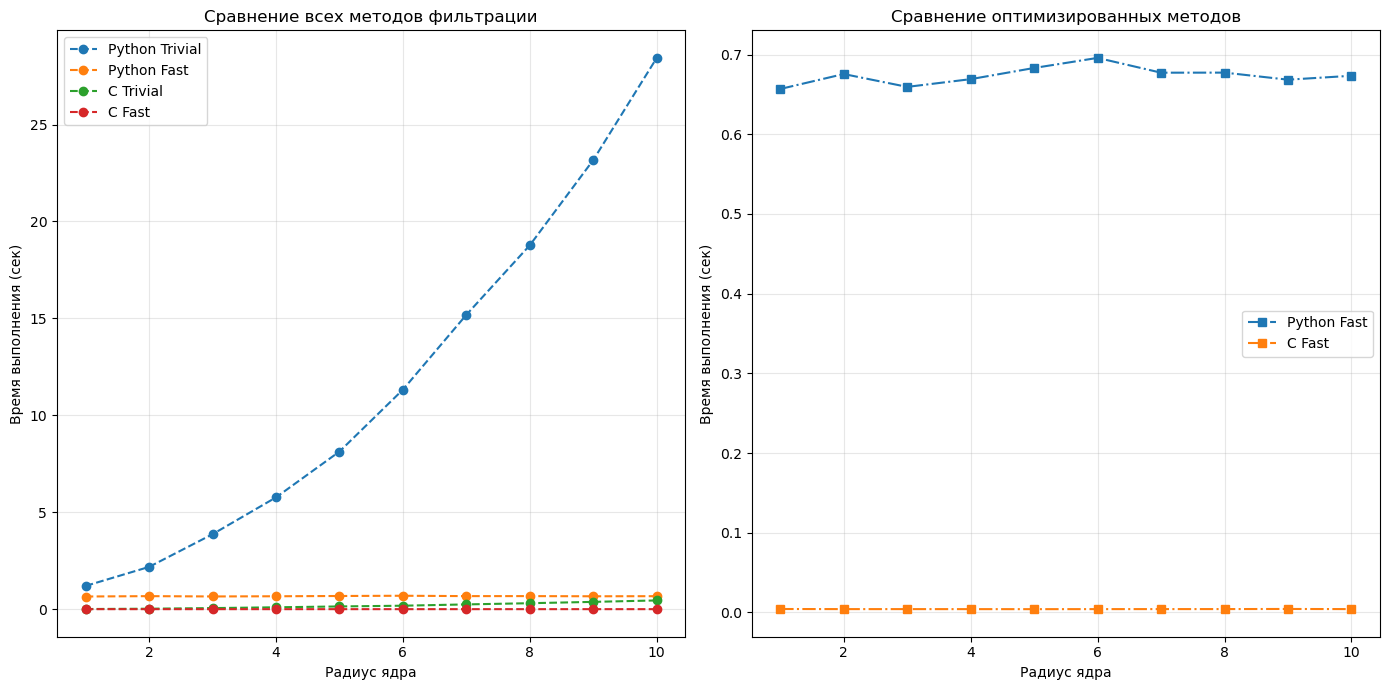

In [9]:
plt.figure(figsize=(14, 7))

# График всех методов
plt.subplot(1, 2, 1)
for label, times in results.items():
    plt.plot(kernel_radii, times, marker='o', linestyle='--', label=label)
plt.title('Сравнение всех методов фильтрации')
plt.xlabel('Радиус ядра')
plt.ylabel('Время выполнения (сек)')
plt.grid(True, alpha=0.3)
plt.legend()

# График только оптимизированных методов
plt.subplot(1, 2, 2)
for label in ['Python Fast', 'C Fast']:
    plt.plot(kernel_radii, results[label], marker='s', linestyle='-.', label=label)
plt.title('Сравнение оптимизированных методов')
plt.xlabel('Радиус ядра')
plt.ylabel('Время выполнения (сек)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### rgb -> hsv

In [ ]:
lib.CVP_ConvImgRGBToHSVInRect.argtypes = [
    ctypes.POINTER(CVP_Image),  
    ctypes.POINTER(CVP_Image),  
    ctypes.c_int,               
    ctypes.c_int,               
    ctypes.c_int,               
    ctypes.c_int                
]
lib.CVP_ConvImgRGBToHSVInRect.restype = None

In [12]:
input_image = cv2.imread('image.jpg')
rgb_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

In [13]:
rgb_image_struct = CVP_Image(
    pixel_data=rgb_image.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte)),
    channels=rgb_image.shape[2],
    image_width=rgb_image.shape[1],
    image_height=rgb_image.shape[0]
)

In [14]:
hsv_image = np.zeros_like(rgb_image, dtype=np.uint8)
hsv_image_struct = CVP_Image(
    pixel_data=hsv_image.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte)),
    channels=hsv_image.shape[2],
    image_width=hsv_image.shape[1],
    image_height=hsv_image.shape[0]
)

lib.CVP_ConvImgRGBToHSVInRect(
    ctypes.byref(rgb_image_struct),
    ctypes.byref(hsv_image_struct),
    0,  # start_x
    0,  # start_y
    rgb_image.shape[1],  # end_x (ширина)
    rgb_image.shape[0]   # end_y (высота)
)

restored_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)


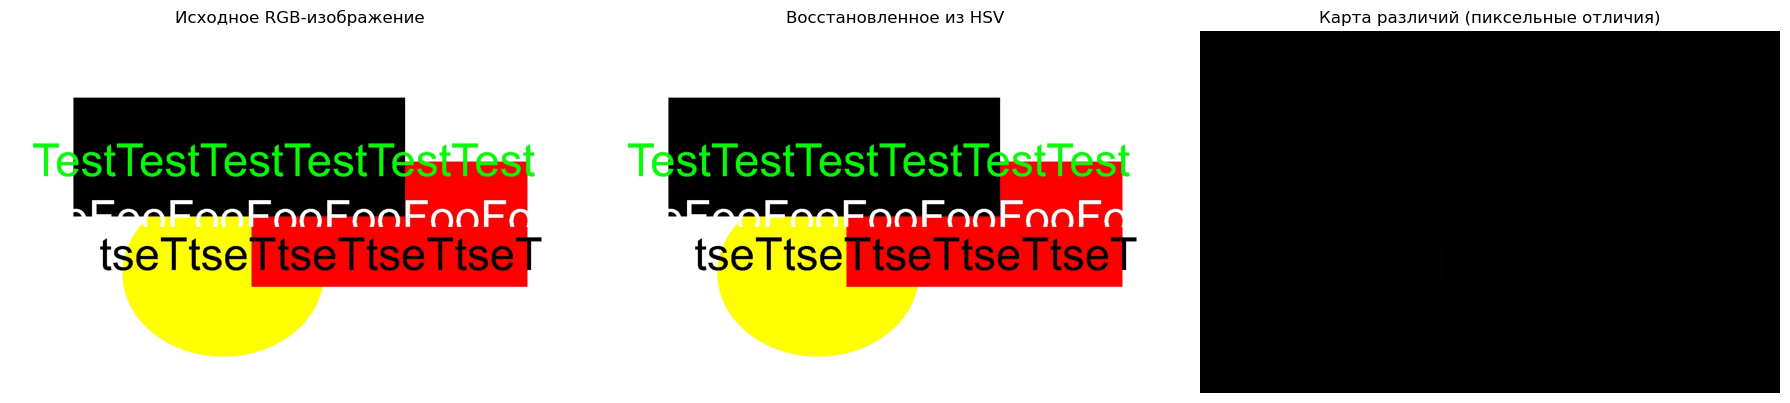

In [16]:
def calculate_difference(original, reconstructed):
    return np.abs(original.astype(np.int16) - reconstructed.astype(np.int16))

pixel_difference = calculate_difference(rgb_image, restored_rgb).astype(np.uint8)

# Визуализация результатов
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plot_titles = [
    "Исходное RGB-изображение",
    "Восстановленное из HSV",
    "Карта различий (пиксельные отличия)"
]

for ax, title, image, cmap in zip(axes, plot_titles, 
                                 [rgb_image, restored_rgb, pixel_difference],
                                 [None, None, 'viridis']):
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    ax.grid(False)

plt.tight_layout()
plt.show()